## AirBnb Housing assignment

The following questions will be answered in this assignment: 
- What will Amsterdam receive from tourist tax if the event lasts a week and there will bee 30.000 visitor?s
- Plot the amount of AirBnb locations per neighbourhood
- Which street in Amstrdam has the most AirBnB apartments?
-Does the data from AirBnB correspond with the data from the Basis Bestanden Gebied Amsterdam (BBGA)?
- How many hotel rooms should be built if Amsterdam wants to accommodate the amount of visitors that can stay in AirBnBs?
- How many different licenses are issues for the available AirBnBs for the event??

In [1]:
import pandas as pd
import os.path
import re

path = "data/listings.csv"

bnb_df = pd.read_csv(path)

visitors = 30000

# To calculate how much tourist tax Amsterdam will receive from visitors that stay in AirBnBs, we need to know the amount of private rooms and
# apartments booked. In order to do this, we need to know how many people can stay per apartment, so we need to extract the amount of beds per
# apartment. This information is contained in the 'name' column in the listings file of AirBnB.
# So, we first splitted the content of the 'name' column and remove the rating. Subsequently we put these splitted
# contents in different columns and added these to the complete dataframe in the listings file. 
# We did this, because some rows did contain a rating and some did not. When they didn't, the contents of successive columns would all move
# one cell forward. Each column would subsequently not contain the corresponding information. For example cell with data about 'Bedrooms' would
# move into the ratings column. With removing the rating data, all 'name' columns only contained the information about property, bedrooms, 
# beds and bathrooms.

# In onderstaande functie worden de ratings verwijderd, door de ster met de cijfers, punt en decimalen en de interpunct te vervangen door een spatie.
# (https://docs.python.org/3/library/re.html; https://stackoverflow.com/questions/69052038/remove-using-regular-expression)
def remove_ratings(cell):
    if isinstance(cell, str):
        return re.sub(r'★(\d+\.\d+|New) · ', '', cell)
    else:
        return cell

# The function is applied to the 'name' column, as can be seen in the print. Subsequently this column is splitted and added to the dataframe.
bnb_df['name'] = bnb_df['name'].map(remove_ratings)
print(bnb_df['name'].head())

bnb_df[['Property', 'Bedrooms', 'Beds', 'Bathrooms']] = bnb_df['name'].str.split(" · ", expand=True)

# Then we selected only the Private rooms
# Selecting a minimum nights of lower than eight, as the event lasts a week. Rooms that have a required number of minimum nights
# higher than eight are not suitable.
# Selecting an availability per year equal or higher than seven, cause an amount lower is not suitable
# We assume that every bed is a two persons bed, this means that in every private room, two persons can sleep.

bnb_pv = bnb_df.loc[(bnb_df['room_type'] == "Private room") & (bnb_df['minimum_nights'] < 8) & (bnb_df['availability_365'] >= 7)]

# calculating how many people can stay in the private rooms
pv_rooms = bnb_pv['room_type'].size
people_private = 2 * pv_rooms

print('The amount of private rooms available is', pv_rooms, '\n')
print('The amount of people that can stay in the available private rooms in Amsterdam is', people_private, '\n')

# Then we selected only entire apartments and extracted how many varieties of bed compositions there are in the apartments

bnb_nf = bnb_df.loc[(bnb_df['room_type'] != "Private room") & (bnb_df['minimum_nights'] < 8) & (bnb_df['availability_365'] >= 7)]

bed_counts = bnb_nf['Beds'].value_counts()

# We made a dataframe from the series that results from the counting of beds
# We removed the strings, 'bed' or 'beds' from the cells, so only the integer is left. In the bed count, still some baths ended up.
# When this happened, the function returned a 0
# Subsequently the total amount of two persons beds was calculated and with this the total amount of people that could sleep in the
# available AirBnB apartments and private rooms
# for .reset_index() = (https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html)
# for iterating over rows with panda = (https://www.geeksforgeeks.org/different-ways-to-iterate-over-rows-in-pandas-dataframe/)

bed_counts_df = bed_counts.reset_index()
bed_counts_df.columns = ['Beds', 'Count']

# function to remove the strings and only return an integer
def extract_integer(cell_value):
    parts = cell_value.split()
    if len(parts) == 2:
        if parts[1] == 'beds':
            return int(parts[0])
        elif parts[1] == 'bed':
            return int(parts[0])
    return 0

# applying the function to the column 'Beds'
bed_counts_df['Beds'] = bed_counts_df['Beds'].apply(extract_integer)

# creating an empty list and filling this with a for loop in which we calculate how many people can stay in the beds
persons_column = []

for index in bed_counts_df.index:
    persons = bed_counts_df['Beds'][index] * bed_counts_df['Count'][index]
    persons_column.append(persons)

# adding the persons_column list to the dataframe bed_counts_df
bed_counts_df['Amount of persons'] = persons_column
print('The amount of beds there are in apartments and how many people can stay in them:\n\n', bed_counts_df, '\n')

# calculating how many people can stay in the apartments
people_ap = int(bed_counts_df['Amount of persons'].sum())
print('The amount of people that can stay in the available AirBnB apartments in Amsterdam is', people_ap, '\n')

#calculating how many people can stay in AirBnBs
airbnb_av = people_private + people_ap
print('The amount of people that can stay in the available AirBnB private rooms and apartments in Amsterdam during the swimming event is', airbnb_av, '\n')

# Subsequently we calculated the tourist tax. To do this, we used the iloc[] method and filled this in the new data frame
# With this we could calculate the total tax Amsterdam would receive from private rooms and apartments
# The tourist tax in Amsterdam is 10% (https://www.amsterdam.nl/veelgevraagd/toeristenbelasting-2c7c2#)

tourist_tax = 0.10

# creating a dataframe which if filled via a for loop in which the price is multiplied with the tax
df_private_tax = pd.DataFrame(columns=['price_tax'])

for index in range(len(bnb_pv)):
    tax = bnb_pv.iloc[index, 9] * tourist_tax
    df_private_tax.loc[index] = [tax]

# calculating the total tax retrieved from private rooms
total_tax_private = df_private_tax['price_tax'].sum()*7
print(f'\nThe total amount of tourist tax Amsterdam will receive from private rooms on AirBnB in a week is \u20ac {total_tax_private: .2f}')

# creating a dataframe which if filled via a for loop in which the price is multiplied with the tax
df_apart_tax = pd.DataFrame(columns=['price_tax'])

for index in bnb_nf.index:
    tax = bnb_nf['price'][index] * tourist_tax
    df_apart_tax.loc[index] = [tax]

# calculating the total tax retrieved from apartments
total_tax_apart = df_apart_tax['price_tax'].sum()*7
print(f'\nThe total amount of tourist tax Amsterdam will receive from apartments on AirBnB in a week is \u20ac {total_tax_apart: .2f} \n')

# Not all 30.000 visitors can stay in AirBnB apartments, as we calculated that there are not enough private rooms and apartments available
# for a week. The other visitors will have to stay in other apartments or hotels. To still calculate the tourist tax received from these
# visitors, we calculated the average price of an AirBnb. With this it was possible to calculate the received tax. We assumed again that
# people would stay in two beds / rooms.

average_price = bnb_df['price'].mean()
amount_not = int(-(-(visitors - people_private - people_ap)/2 // 1))
tax_other = amount_not*average_price*tourist_tax*7

print(f'\n Average price per night of AirBnBs in Amsterdam is \u20ac {average_price: .2f} \n')
print(f'\n The amount of rooms that the people have to stay in for whom there are no available AirBnBs is', amount_not, '\n')
print(f'\nThe total amount of tourist tax Amsterdam will receive from people staying at other places than AirBnB is \u20ac {tax_other: .2f} \n')

total_tax = total_tax_private + total_tax_apart + tax_other
print(f'\nThe total amount of tourist tax Amsterdam will receive from bookings during the event with 30.000 visitors in a week is \u20ac {total_tax: .2f}')

0    Condo in Amsterdam · 1 bedroom · 1 bed · 1 sha...
1    Rental unit in Amsterdam · 1 bedroom · 1 bed ·...
2    Boat in Amsterdam · 1 bedroom · 1 bed · 1.5 baths
3    Houseboat in Amsterdam · 3 bedrooms · 3 beds ·...
4    Rental unit in Amsterdam · 1 bedroom · 1 bed ·...
Name: name, dtype: object
The amount of private rooms available is 1427 

The amount of people that can stay in the available private rooms in Amsterdam is 2854 

The amount of beds there are in apartments and how many people can stay in them:

     Beds  Count  Amount of persons
0      1   1511               1511
1      2    863               1726
2      3    371               1113
3      4    231                924
4      5     66                330
5      6     31                186
6      0     15                  0
7      7     10                 70
8      0      9                  0
9     12      5                 60
10     8      4                 32
11    13      2                 26
12    16      2         

### Plotting the amount of AirBnb locations per neighbourhood

neighbourhood
De Baarsjes - Oud-West                    1382
Centrum-West                              1006
De Pijp - Rivierenbuurt                    935
Centrum-Oost                               793
Zuid                                       599
Westerpark                                 584
Oud-Oost                                   506
Bos en Lommer                              424
Oud-Noord                                  402
Oostelijk Havengebied - Indische Buurt     320
Watergraafsmeer                            262
Noord-West                                 218
IJburg - Zeeburgereiland                   183
Slotervaart                                164
Noord-Oost                                 137
Geuzenveld - Slotermeer                    116
Buitenveldert - Zuidas                     100
De Aker - Nieuw Sloten                      74
Gaasperdam - Driemond                       51
Bijlmer-Centrum                             47
Osdorp                                      44

Text(0.5, 1.0, 'Amount of AirBnBs per neighbourhood in Amsterdam')

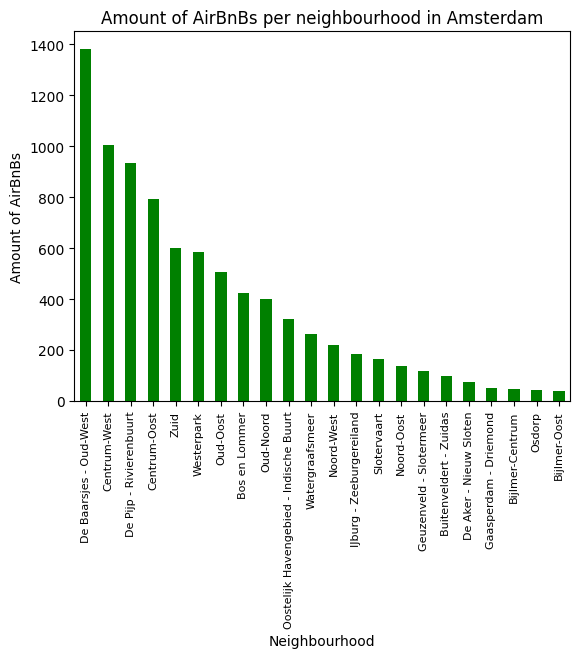

In [2]:
import matplotlib.pyplot as plt

# To plot the amount of AirBnB locations per neighbourhood, we calculated how much locations there were per neighbourhood.

wijk_counts = bnb_df['neighbourhood'].value_counts()
print(wijk_counts)

# This could be plotted with a bar plot.
wijk_counts.plot.bar(color = 'green')
plt.xlabel("Neighbourhood", size = 10)
plt.ylabel("Amount of AirBnBs", size = 10)
plt.xticks(rotation = 90, size = 8)
plt.title('Amount of AirBnBs per neighbourhood in Amsterdam', size = 12)

### Which street has the most AirBnb apartments

In [4]:
from geopy.geocoders import Nominatim

import geocoder

# To find out which street has the most AirBnB apartments, we needed to import geocoder. We took the 'latitude' and 'longitude' columns
# and iterated over these, extracting the coordinates from each apartment. With the geocoder we could get the street from these coordinates.
# At one point we get an error, which says 'Coords are not within the world's geographical boundary'. We went further with all the streets that
# were calculated.
# source for geocoding = (https://datascientyst.com/reverse-geocoding-latitude-longitude-city-country-python-pandas/)

bnb_street = bnb_df[['latitude', 'longitude']]

# creating an empty dataframe and list and and filling this with a for loop where we get the streets from the coordinates
df_street = pd.DataFrame(columns=['coordinates'])
list_streets = []


for index in bnb_street.index:
    coordinates = bnb_df['latitude'][index], bnb_df['longitude'][index]
    df_street.loc[index] = [coordinates]
    g = geocoder.osm(df_street['coordinates'][index], method='reverse')
    list_streets.append(g.json['street'])
    

In [ ]:
# We made a set out of the list, so every street only occured once.
# This way we could count how many times a street occured in the list, using the set and we could now find which street has the most AirBnBs
# (https://medium.com/@Saslow/how-do-you-get-the-matching-elements-in-an-integer-array-2ea5d01712bd)

list_streets_complete = list_streets #do not overwrite this code when running the geocoder function
set_streets = set(list_streets_complete)

# function to count how many streets occured in the list using the set
def count_elements_in_set(input_list, input_set):
    element_counts = {}
    for element in input_list:
        if element in input_set:
            if element in element_counts:
                element_counts[element] += 1
            else:
                element_counts[element] = 1
    return element_counts

# using the function to create a dataframe in which we count how often streets occur
result = count_elements_in_set(list_streets_complete, set_streets)
result_df = pd.DataFrame(result, index=['Count']).T
sorted_df = result_df.sort_values(by='Count', ascending=False)
print(sorted_df, '\n')

# finding in which street most AirBnB locations can be found
street_with_highest_count = sorted_df.index[0]
print('The street that has the most AirBnB locations is the', street_with_highest_count)

In [ ]:
import pandas as pd
from plotly.express import bar
import matplotlib.pyplot as plt

# We extracted the data about the amount of AirBnBs per neighbourhood that is corresponding to the neighbourhoods of the AirBnB data.
# We had to replace some names, so the neighbourhoods names in both dataframes corresponded. We then counted merged the dataframes
# in order to plot them in the same graph
# (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.merge.html)

bbga_xlsx = 'data/2023_BBGA_0614_cf8d825e89_1.xlsx'
xlsx_data = pd.read_excel(bbga_xlsx)

# Three columns are extracted from the excel file and the cells with information about the neighbourhoods 
# corresponding with the AirBnB data are extracted
df_airbnb = xlsx_data[['gebiednaam', 'sdnaam', 'BHVESTAIRBNB']]
df_airbnb_wijken = df_airbnb.iloc[3937:3962]

# The names of the neighbourhoods are replaced with the corresponding name in the AirBnB data and this is applied to the 'gebiedsnaam' column
replace_streets = {
    "Oud-Zuid": "Zuid",
    "De Aker, Sloten, Nieuw-Sloten": "De Aker - Nieuw Sloten",
    "Oud West, De Baarsjes": "De Baarsjes - Oud-West",
    "Geuzenveld, Slotermeer": "Geuzenveld - Slotermeer",
    "De Pijp, Rivierenbuurt": "De Pijp - Rivierenbuurt",
    "IJburg, Zeeburgereiland": "IJburg - Zeeburgereiland",
    "Buitenveldert, Zuidas": "Buitenveldert - Zuidas",
    "Gaasperdam": "Gaasperdam - Driemond",
    "Indische Buurt, Oostelijk Havengebied": "Oostelijk Havengebied - Indische Buurt"
}

df_airbnb_wijken['gebiednaam'] = df_airbnb_wijken['gebiednaam'].replace(replace_streets)

# excel file converted to csv
df_airbnb_wijken.to_csv("bbga_data_needed.csv", index=False)
df_wijken = pd.read_csv('bbga_data_needed.csv')

# AirBnB data column is renamed and it is calculated how often these occur
bnb_df.rename(columns={"neighbourhood": "gebiednaam"}, inplace=True)

count_gebied = bnb_df['gebiednaam'].value_counts().reset_index().rename(columns={'index': 'gebiednaam', 0 : 'count'})

# BBGA data and AirBnB data are merged into one dataframe
merged_df = pd.merge(df_wijken, count_gebied, on='gebiednaam')
merged_df.rename(columns={"BHVESTAIRBNB": "BHVESTAIRBNB : BBGA", "count" : "AirBnB"}, inplace=True)
print(merged_df)

# Plotting the merged data frame
ax = merged_df.plot(kind='bar', x='gebiednaam', logy=False, rot=0, width=0.9)
plt.xlabel('Neighbourhood')
plt.ylabel('Amount of AirBnBs')
plt.title('Comparison of amount of the data Airbnbs by the BBGA data and the AirBnB data per neighbourhood', size = 12)
plt.xticks(rotation = 90, size = 8)
plt.show()

In [ ]:
# Before we already calculated the amount of people that could sleep in the available private rooms and in the available apartments on AirBnB
# for a week. All other visitors already had to stay in other accommodations. Here we calculated the amount of hotelrooms that would be needed
# to accommodate the people that could stay in AirBnBs. We assume people would sleep in two person rooms.

airbnb_av = people_private + people_ap
hotelrooms = int(-(-airbnb_av/2 // 1))
percentage = (airbnb_av / visitors) * 100
print('The amount of hotelrooms that needs to be build extra is', hotelrooms)
print(f'\nThe percentage of visitors that can stay in AirBnBs is {percentage: .1f}')

In [ ]:
# We calculated the licenses that were issues for the available private rooms and apartments on AirBnB
# (https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.nunique.html)

license_pv = bnb_pv['license;'].nunique()
license_ap = bnb_nf['license;'].nunique()
print('The number of licenses issued for the AirBnBs booked during the event is', license_pv + license_ap)

Amsterdam will receive a large amount of tourist tax. However this is mostly received from other accommodations than AirBbnb.
This is because there are not a lot of available AirBnbs in the city compared to the number of visitors. We can see in the 
graph that compares the BBGA data with the AirBnB data, that there are more AirBnBs registered in the BBGA than the AirBnb data shows.
The percentage of people that can stay in AirBnBs is 30,3%. This amount is not very high, but in order to allow other tourist is the city as well,
we consider this form of accomodation valuable to the city.


## Links

- https://docs.python.org/3/library/re.html
- https://stackoverflow.com/questions/69052038/remove-using-regular-expression
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html
- https://www.geeksforgeeks.org/different-ways-to-iterate-over-rows-in-pandas-dataframe/
- https://www.amsterdam.nl/veelgevraagd/toeristenbelasting-2c7c2#
- https://datascientyst.com/reverse-geocoding-latitude-longitude-city-country-python-pandas/
- https://medium.com/@Saslow/how-do-you-get-the-matching-elements-in-an-integer-array-2ea5d01712bd
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.nunique.html
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.merge.html
- Stack overflow is used for multiple lines